# Data Gathering and Preparation

## Data pipeline

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="My First Project-987bc028721c.json"

In [2]:
from google.cloud import bigquery
client = bigquery.Client()

query = (
   """
  
  CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    ACOS(ROUND(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2)),15)))
);

SELECT  d.pickup_datetime, d.trip_distance, d.fare_amount,d.dropoff_datetime,d.pickup_longitude, d.pickup_latitude, d.dropoff_longitude, d.dropoff_latitude, weather_data.*, d.my_date,d.my_hour,EXTRACT(dayofweek from d.pickup_datetime) as week, HAVERSINE(d.dropoff_latitude,d.dropoff_longitude, d.pickup_latitude, d.pickup_longitude) AS distance_in_km
,TIMESTAMP_DIFF( TIMESTAMP (d.dropoff_datetime),TIMESTAMP ( d.pickup_datetime), SECOND) as travel_time,
IF(EXTRACT(dayofweek from d.pickup_datetime)=6 or EXTRACT(dayofweek from d.pickup_datetime)=7, 0,1) as week_index

FROM (
SELECT * , EXTRACT(date from pickup_datetime) as my_date , EXTRACT(hour from pickup_datetime) as my_hour,
EXTRACT(month from pickup_datetime) as my_month,
row_number()over(partition by EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)
                   ORDER BY  EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)) as row_num
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` 
) AS d

INNER JOIN
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) as weather_data
    on TIMESTAMP( EXTRACT (DATE FROM d.pickup_datetime)) = TIMESTAMP(weather_data.date_of_year2)

WHERE d.row_num <=500 AND pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL AND HAVERSINE(d.dropoff_latitude,d.dropoff_longitude, d.pickup_latitude, d.pickup_longitude)>0.1

    """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.to_csv("my_500_d_h_new",index = False)

## Data integrity checks

In [2]:
#df = pd.read_csv('my_500_d_h_new.csv')

In [3]:
df.head()

,pickup_datetime,trip_distance,fare_amount,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,my_date,my_hour,week,distance_in_km,travel_time,week_index
0,2016-01-24 14:25:00,1.75,11.0,2016-01-24 14:39:36,-73.978119,40.729282,-74.006973,40.741669,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,2.790409,876,1
1,2016-01-24 14:45:02,1.58,7.5,2016-01-24 14:52:46,-74.007202,40.715954,-73.997368,40.736511,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,2.428183,464,1
2,2016-01-24 14:03:03,2.28,10.5,2016-01-24 14:15:48,-73.976593,40.747871,-73.953445,40.771702,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,3.285323,765,1
3,2016-01-24 14:16:17,0.83,5.5,2016-01-24 14:22:02,-73.981895,40.769604,-73.985023,40.778931,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,1.068592,345,1
4,2016-01-24 14:12:41,0.80,5.5,2016-01-24 14:17:59,-73.951347,40.778667,-73.959930,40.768581,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,1.332436,318,1


In [4]:
df = df.rename(columns={'my_hour':'Hour'})

In [5]:
df.describe()

,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,Hour,week,distance_in_km,travel_time,week_index
count,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2128531.0,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06,2.128531e+06
mean,3.206771e+00,1.320066e+01,-7.378585e+01,4.064694e+01,-7.385203e+01,4.068569e+01,2016.0,3.510100e+00,1.565432e+01,5.125236e+01,3.092333e+01,3.253902e+01,9.657619e-02,4.642920e-02,2.760481e-01,7.388382e-02,1.151365e+01,4.000469e+00,3.954327e+01,9.382703e+02,7.149720e-01
std,3.870717e+00,1.137041e+01,3.719330e+00,2.049024e+00,2.962094e+00,1.632350e+00,0.0,1.705873e+00,8.772330e+00,1.554929e+01,1.455006e+02,1.628923e+02,2.507080e-01,2.104128e-01,4.470410e-01,2.615818e-01,6.912568e+00,1.995599e+00,5.553631e+02,5.972442e+03,4.514279e-01
min,0.000000e+00,-4.050000e+02,-8.293929e+01,0.000000e+00,-7.878560e+01,0.000000e+00,2016.0,1.000000e+00,1.000000e+00,6.900000e+00,1.700000e+00,1.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000162e-01,-5.243209e+06,0.000000e+00
25%,1.030000e+00,6.500000e+00,-7.399196e+01,4.073583e+01,-7.399105e+01,4.073454e+01,2016.0,2.000000e+00,8.000000e+00,3.910000e+01,8.700000e+00,3.700000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,2.000000e+00,1.286296e+00,3.810000e+02,0.000000e+00
50%,1.800000e+00,9.500000e+00,-7.398209e+01,4.075293e+01,-7.397897e+01,4.075414e+01,2016.0,4.000000e+00,1.600000e+01,5.140000e+01,9.800000e+00,4.900000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01,4.000000e+00,2.233960e+00,6.430000e+02,1.000000e+00
75%,3.510000e+00,1.500000e+01,-7.396708e+01,4.076743e+01,-7.396009e+01,4.076972e+01,2016.0,5.000000e+00,2.300000e+01,6.340000e+01,1.000000e+01,6.400000e+00,5.000000e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.700000e+01,6.000000e+00,4.362873e+00,1.057000e+03,1.000000e+00
max,2.210000e+02,2.020370e+03,0.000000e+00,4.355344e+01,0.000000e+00,4.982042e+01,2016.0,6.000000e+00,3.100000e+01,7.960000e+01,9.999000e+02,9.999000e+02,1.820000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.300000e+01,7.000000e+00,8.726929e+03,3.593894e+06,1.000000e+00


In [6]:
df.isnull().sum()

pickup_datetime      0
trip_distance        0
fare_amount          0
dropoff_datetime     0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
date_of_year2        0
year                 0
mo                   0
da                   0
temp                 0
visib                0
wdsp                 0
prcp                 0
fog                  0
rain_drizzle         0
snow_ice_pellets     0
my_date              0
Hour                 0
week                 0
distance_in_km       0
travel_time          0
week_index           0
dtype: int64

### We use the two tables above to check whether there exist unexpected values or not. We find there are no missing values in our dataset. There are some strange values in some variables. For example, in the fare_amount variable, it has negative values. In the following code, we will deal with these kinds of values.

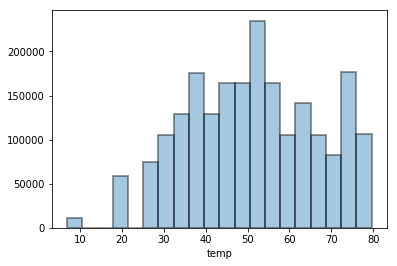

In [7]:
sns.distplot(df['temp'], bins=20, kde=False,hist_kws=dict(edgecolor="k", linewidth=2))

### At first, we check outliers in the temp variable. From above, it does not have outliers in the variable.

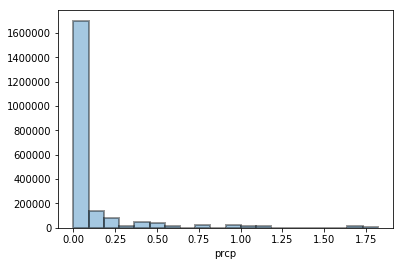

In [8]:
sns.distplot(df['prcp'], bins=20, kde=False,hist_kws=dict(edgecolor="k", linewidth=2))

### Secondly, we check whether 99.99 is in the prcp variable, if exists, set to 0.00. From the histogram, it shows there is no 99.99 in the variable.

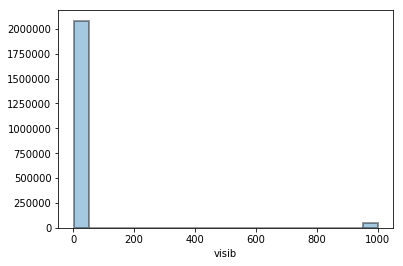

In [9]:
sns.distplot(df['visib'], kde=False, bins=20,hist_kws=dict(edgecolor="k", linewidth=2))

### Thirdly, we check whether 999.99 is in the visib variable, if exists, set to 0.00. From the histogram, it shows there are 999.99 in the variable. We will set it to 0.00 in the feature engineering part.

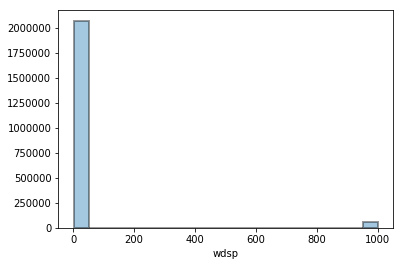

In [10]:
df['wdsp'] = df.wdsp.astype(float)
sns.distplot(df['wdsp'], kde=False, bins=20,hist_kws=dict(edgecolor="k", linewidth=2))

### Fourthly, we check whether 999.99 is in the wdsp variable, if exists, set to 0.00. From the histogram, it shows there are 999.99 in the variable. We will set it to 0.00 in the feature engineering part.

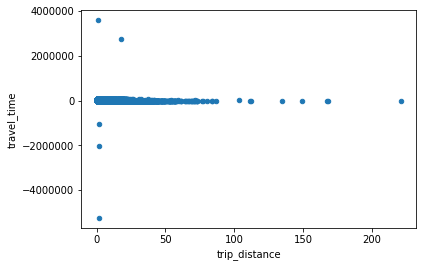

In [11]:
df.plot(x='trip_distance',y='travel_time',kind='scatter')

### Check whether there are unexpected values in the trip_distance and travel_time variables.

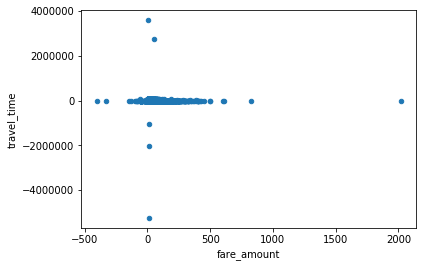

In [12]:
df.plot(x='fare_amount',y='travel_time',kind='scatter')

### Check whether there are unexpected values in the fare_amount variable


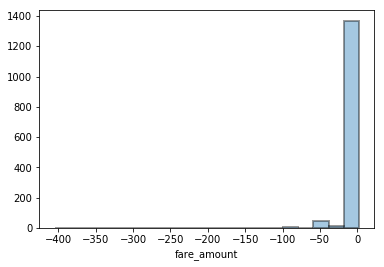

In [13]:
sns.distplot(df[df['fare_amount']<2.5]['fare_amount'],kde=False,bins=20,hist_kws=dict(edgecolor="k", linewidth=2))

### Check whether there are values less than 2.5 in the fare_amount variable, since the starting price for a trip of yellow cab is 2.5. It is impossible we will have some values less than 2.5.

### By checking the dataset, there are no redundant or non-sensical variables. There is no imformation leakage.

## Feature Engineering

### Remove unexpected values in the weather feature.


In [7]:
df = df.drop(df[df['temp'] == 9999.9].index)
df[df['prcp']==99.99]['prcp'] = 0.00
df['visib'] = df['visib'].mask(df['visib'] == 999.9,df['visib'].median())
df['wdsp'] = df.wdsp.astype(float)
df['wdsp'] = df['wdsp'].mask(df['wdsp'] == 999.9,df['wdsp'].median())

### Remove unexpected trip distance, travel time and fare amount in the dataset. 

In [8]:
df = df.drop(df[(df['trip_distance'] == 0) | (df['travel_time'] == 0) | (df['trip_distance'] > 14) | (df['distance_in_km'] > 20) | (df['fare_amount'] < 2.5) |(df['fare_amount'] > 250) | (df['travel_time'] > 3600)].index)

In [9]:
df.describe()

,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,Hour,week,distance_in_km,travel_time,week_index
count,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2035965.0,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06,2.035965e+06
mean,2.651190e+00,1.165748e+01,-7.397681e+01,4.075208e+01,-7.397275e+01,4.075262e+01,2016.0,3.507352e+00,1.564558e+01,5.121860e+01,9.092567e+00,5.112161e+00,9.631208e-02,4.633970e-02,2.762626e-01,7.411866e-02,1.154192e+01,4.007593e+00,3.132468e+00,7.494579e+02,7.139568e-01
std,2.526471e+00,7.647665e+00,2.935461e-02,2.526460e-02,3.140708e-02,3.138717e-02,0.0,1.705235e+00,8.773204e+00,1.555167e+01,1.404690e+00,2.108116e+00,2.498169e-01,2.102198e-01,4.471484e-01,2.619640e-01,6.921620e+00,1.994735e+00,2.808415e+00,5.136151e+02,4.519099e-01
min,1.000000e-02,2.500000e+00,-7.482381e+01,3.807460e+01,-7.486515e+01,3.809633e+01,2016.0,1.000000e+00,1.000000e+00,6.900000e+00,1.700000e+00,1.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000162e-01,1.000000e+00,0.000000e+00
25%,1.000000e+00,6.500000e+00,-7.399219e+01,4.073748e+01,-7.399112e+01,4.073635e+01,2016.0,2.000000e+00,8.000000e+00,3.910000e+01,8.700000e+00,3.700000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,2.000000e+00,1.256276e+00,3.730000e+02,0.000000e+00
50%,1.720000e+00,9.500000e+00,-7.398234e+01,4.075372e+01,-7.397923e+01,4.075478e+01,2016.0,4.000000e+00,1.600000e+01,5.140000e+01,9.800000e+00,4.900000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01,4.000000e+00,2.138958e+00,6.210000e+02,1.000000e+00
75%,3.200000e+00,1.400000e+01,-7.396837e+01,4.076785e+01,-7.396130e+01,4.077008e+01,2016.0,5.000000e+00,2.300000e+01,6.340000e+01,1.000000e+01,6.200000e+00,5.000000e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.800000e+01,6.000000e+00,3.942580e+00,9.950000e+02,1.000000e+00
max,1.400000e+01,2.500000e+02,-7.226786e+01,4.110666e+01,-7.230011e+01,4.111000e+01,2016.0,6.000000e+00,3.100000e+01,7.960000e+01,1.000000e+01,1.280000e+01,1.820000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.300000e+01,7.000000e+00,1.996572e+01,3.600000e+03,1.000000e+00


In [10]:
df = df.reset_index(drop=True)

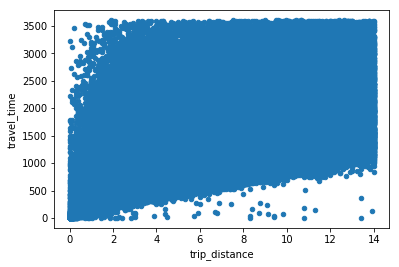

In [22]:
df.plot(x='trip_distance',y='travel_time',kind='scatter')

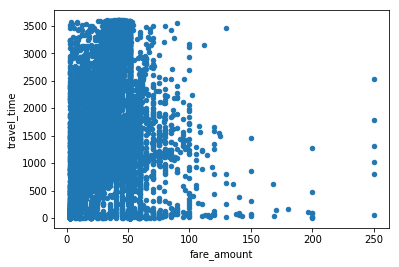

In [23]:
df.plot(x='fare_amount',y='travel_time',kind='scatter')

### Convert categorical features into one hot encoded dummy variables.

In [11]:
def rain_level(prcp):
    if prcp==0.0:
        return 'No'
    elif (prcp>0.0) & (prcp<0.098):
        return 'Light'
    elif (prcp>=0.098) & (prcp<0.39):
        return 'Moderate'
    else:
        return 'Heavy'

In [12]:
df['rain_level'] = df.apply(lambda x: rain_level(x['prcp']),axis=1)

In [13]:
df = pd.get_dummies(df,columns=['rain_level'],prefix=['rain'],drop_first=True)

In [14]:
rush_hour = [7,8,9,10,15,16,17,18,19]
df['rush_hour_ind']=df['Hour'].apply(lambda x: 1 if x in rush_hour else 0)

In [15]:
df.head()

,pickup_datetime,trip_distance,fare_amount,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,my_date,Hour,week,distance_in_km,travel_time,week_index,rain_Light,rain_Moderate,rain_No,rush_hour_ind
0,2016-01-24 14:25:00,1.75,11.0,2016-01-24 14:39:36,-73.978119,40.729282,-74.006973,40.741669,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,2.790409,876,1,0,0,0,0
1,2016-01-24 14:45:02,1.58,7.5,2016-01-24 14:52:46,-74.007202,40.715954,-73.997368,40.736511,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,2.428183,464,1,0,0,0,0
2,2016-01-24 14:03:03,2.28,10.5,2016-01-24 14:15:48,-73.976593,40.747871,-73.953445,40.771702,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,3.285323,765,1,0,0,0,0
3,2016-01-24 14:16:17,0.83,5.5,2016-01-24 14:22:02,-73.981895,40.769604,-73.985023,40.778931,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,1.068592,345,1,0,0,0,0
4,2016-01-24 14:12:41,0.80,5.5,2016-01-24 14:17:59,-73.951347,40.778667,-73.959930,40.768581,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,1.332436,318,1,0,0,0,0


### Adding Historical Feature Geohash based latitude and longtitude variables

In [16]:
# We obtain geohash with precision = 6 for all data
df['pickup_geohash'] = df.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df['dropoff_geohash'] = df.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)

In [17]:
df['gh'] = df['pickup_geohash'] + df['dropoff_geohash']

In [18]:
# We calculate average historical ‘travel time’ in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_time_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_travel_time']
df = pd.concat([df,result],axis=1)

# We calculate average historical ‘travel time’ in terms of the same pickup area, drop off area, and pickup hour, with geohash perceision = 6.
df_transform_hr = df.sort_values('pickup_datetime').groupby(['gh','Hour'])['travel_time'].transform('shift')
df_transform_hr = pd.DataFrame(df_transform_hr)
df_transform_hr.columns = ['travel_time_shift_1']
df = pd.concat([df,df_transform_hr],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh','Hour'])['travel_time_shift_1'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=('gh','Hour'),drop=True)
result.columns = ['avg_hr_travel_time']
df = pd.concat([df,result],axis=1)

In [19]:
# We calculate average historical 'trip distance' in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['trip_distance'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_dist_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_dist_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_trip_dist']
df = pd.concat([df,result],axis=1)

# We calculate average historical 'trip distance' in terms of the same pickup area, drop off area, and pickup hour, with geohash perceision = 6.
df_transform_hr = df.sort_values('pickup_datetime').groupby(['gh','Hour'])['trip_distance'].transform('shift')
df_transform_hr = pd.DataFrame(df_transform_hr)
df_transform_hr.columns = ['travel_dist_shift_1']
df = pd.concat([df,df_transform_hr],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh','Hour'])['travel_dist_shift_1'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=('gh','Hour'),drop=True)
result.columns = ['avg_hr_trip_dist']
df = pd.concat([df,result],axis=1)

In [20]:
# We calculate average historical 'fare amount' in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['fare_amount'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['fare_amount_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['fare_amount_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_fare_amount']
df = pd.concat([df,result],axis=1)

# We calculate average historical ‘fare amount’ in terms of the same pickup area, drop off area, and pickup hour, with geohash perceision = 6.
df_transform_hr = df.sort_values('pickup_datetime').groupby(['gh','Hour'])['fare_amount'].transform('shift')
df_transform_hr = pd.DataFrame(df_transform_hr)
df_transform_hr.columns = ['fare_amount_shift_1']
df = pd.concat([df,df_transform_hr],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh','Hour'])['fare_amount_shift_1'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=('gh','Hour'),drop=True)
result.columns = ['avg_hr_fare_amount']
df = pd.concat([df,result],axis=1)

In [21]:
df = df.fillna(0)

In [22]:
df.head()

,pickup_datetime,trip_distance,fare_amount,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,my_date,Hour,week,distance_in_km,travel_time,week_index,rain_Light,rain_Moderate,rain_No,rush_hour_ind,pickup_geohash,dropoff_geohash,gh,travel_time_shift,avg_travel_time,travel_time_shift_1,avg_hr_travel_time,travel_dist_shift,avg_trip_dist,travel_dist_shift_1,avg_hr_trip_dist,fare_amount_shift,avg_fare_amount,fare_amount_shift_1,avg_hr_fare_amount
0,2016-01-24 14:25:00,1.75,11.0,2016-01-24 14:39:36,-73.978119,40.729282,-74.006973,40.741669,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,2.790409,876,1,0,0,0,0,dr5rsw,dr5rgb,dr5rswdr5rgb,924.0,578.157895,574.0,567.000000,2.42,1.717895,1.50,1.583333,11.0,8.710526,8.5,8.500000
1,2016-01-24 14:45:02,1.58,7.5,2016-01-24 14:52:46,-74.007202,40.715954,-73.997368,40.736511,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,2.428183,464,1,0,0,0,0,dr5reu,dr5rsp,dr5reudr5rsp,411.0,486.537313,281.0,395.250000,1.30,1.596567,1.18,1.465000,6.5,7.888060,6.0,7.125000
2,2016-01-24 14:03:03,2.28,10.5,2016-01-24 14:15:48,-73.976593,40.747871,-73.953445,40.771702,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,3.285323,765,1,0,0,0,0,dr5ru9,dr5rvn,dr5ru9dr5rvn,438.0,626.939394,736.0,669.000000,2.32,2.404848,2.88,2.672000,9.0,10.070707,11.0,10.700000
3,2016-01-24 14:16:17,0.83,5.5,2016-01-24 14:22:02,-73.981895,40.769604,-73.985023,40.778931,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,1.068592,345,1,0,0,0,0,dr5rut,dr5rur,dr5rutdr5rur,518.0,466.283019,518.0,571.428571,1.47,1.176981,1.47,1.275714,7.0,7.103774,7.0,7.928571
4,2016-01-24 14:12:41,0.80,5.5,2016-01-24 14:17:59,-73.951347,40.778667,-73.959930,40.768581,2016-01-24,2016,1,24,26.7,7.4,6.3,1.82,1,0,1,2016-01-24,14,1,1.332436,318,1,0,0,0,0,dr5rvp,dr5rvj,dr5rvpdr5rvj,342.0,398.503185,224.0,492.708333,0.80,1.020223,0.60,0.950417,5.5,6.442675,4.5,6.937500


In [23]:
df_final = df.drop(['pickup_datetime', 'dropoff_datetime','trip_distance','fare_amount','date_of_year2','year','mo','da','prcp','my_date','week','pickup_geohash','dropoff_geohash','gh','travel_time_shift','travel_time_shift_1','travel_dist_shift','travel_dist_shift_1','fare_amount_shift','fare_amount_shift','fare_amount_shift_1'],axis=1)

### We will use the following variables to build our models. We select different features for different models.

In [24]:
df_final.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,temp,visib,wdsp,fog,rain_drizzle,snow_ice_pellets,Hour,distance_in_km,travel_time,week_index,rain_Light,rain_Moderate,rain_No,rush_hour_ind,avg_travel_time,avg_hr_travel_time,avg_trip_dist,avg_hr_trip_dist,avg_fare_amount,avg_hr_fare_amount
0,-73.978119,40.729282,-74.006973,40.741669,26.7,7.4,6.3,1,0,1,14,2.790409,876,1,0,0,0,0,578.157895,567.000000,1.717895,1.583333,8.710526,8.500000
1,-74.007202,40.715954,-73.997368,40.736511,26.7,7.4,6.3,1,0,1,14,2.428183,464,1,0,0,0,0,486.537313,395.250000,1.596567,1.465000,7.888060,7.125000
2,-73.976593,40.747871,-73.953445,40.771702,26.7,7.4,6.3,1,0,1,14,3.285323,765,1,0,0,0,0,626.939394,669.000000,2.404848,2.672000,10.070707,10.700000
3,-73.981895,40.769604,-73.985023,40.778931,26.7,7.4,6.3,1,0,1,14,1.068592,345,1,0,0,0,0,466.283019,571.428571,1.176981,1.275714,7.103774,7.928571
4,-73.951347,40.778667,-73.959930,40.768581,26.7,7.4,6.3,1,0,1,14,1.332436,318,1,0,0,0,0,398.503185,492.708333,1.020223,0.950417,6.442675,6.937500


In [25]:
df_final.shape

(2035965, 24)

In [ ]:
#df_final.to_csv('cleanned_500_final.csv')

# Exploratory Analysis

In [27]:
df_corr = df_final[['travel_time','temp','visib','wdsp','fog','rain_drizzle','snow_ice_pellets','Hour','distance_in_km','week_index','rain_Light','rain_Moderate','rain_No','rush_hour_ind','avg_travel_time','avg_hr_travel_time','avg_trip_dist','avg_hr_trip_dist','avg_fare_amount','avg_hr_fare_amount']]
df_corr.corr()

,travel_time,temp,visib,wdsp,fog,rain_drizzle,snow_ice_pellets,Hour,distance_in_km,week_index,rain_Light,rain_Moderate,rain_No,rush_hour_ind,avg_travel_time,avg_hr_travel_time,avg_trip_dist,avg_hr_trip_dist,avg_fare_amount,avg_hr_fare_amount
travel_time,1.000000,0.050748,0.000908,-0.026896,-0.016820,0.000226,-0.028281,0.077411,0.709126,0.003000,-0.002644,-0.009564,0.010224,0.054446,0.658820,0.439416,0.638492,0.442113,0.635949,0.402509
temp,0.050748,1.000000,-0.121291,-0.517004,-0.108841,0.131070,-0.337456,-0.000565,0.017913,0.017008,-0.011853,-0.015761,0.022540,-0.002025,0.095364,0.156106,0.050682,0.116002,0.072425,0.148288
visib,0.000908,-0.121291,1.000000,-0.052566,-0.424152,-0.450089,-0.272774,0.008225,0.004853,-0.019702,-0.015871,-0.214500,0.418923,-0.000158,-0.012740,-0.024587,-0.004521,-0.016430,-0.009064,-0.023865
wdsp,-0.026896,-0.517004,-0.052566,1.000000,0.098530,0.053188,0.231113,-0.005941,-0.013116,0.011055,-0.042451,0.101073,-0.154995,0.000083,-0.052242,-0.080384,-0.028659,-0.060073,-0.039900,-0.075689
fog,-0.016820,-0.108841,-0.424152,0.098530,1.000000,0.155710,0.382180,-0.001244,-0.003102,-0.018664,-0.041317,0.085353,-0.219799,0.003468,-0.010182,-0.016572,-0.006089,-0.014497,-0.008095,-0.016672
rain_drizzle,0.000226,0.131070,-0.450089,0.053188,0.155710,1.000000,-0.033490,0.000363,-0.000433,-0.020879,0.136266,0.278274,-0.386176,-0.000373,0.016802,0.027734,0.008721,0.019797,0.013118,0.027159
snow_ice_pellets,-0.028281,-0.337456,-0.272774,0.231113,0.382180,-0.033490,1.000000,-0.000598,-0.009081,0.051985,0.182021,0.094334,-0.221411,0.003844,-0.019663,-0.030051,-0.012097,-0.024689,-0.015534,-0.028683
Hour,0.077411,-0.000565,0.008225,-0.005941,-0.001244,0.000363,-0.000598,1.000000,-0.096310,0.004221,0.000299,-0.000100,-0.000055,0.186728,-0.035132,0.089553,-0.070225,-0.055704,-0.055651,0.006393
distance_in_km,0.709126,0.017913,0.004853,-0.013116,-0.003102,-0.000433,-0.009081,-0.096310,1.000000,0.014306,-0.002931,0.000072,0.003264,-0.110315,0.693455,0.297467,0.835884,0.538265,0.777349,0.392378
week_index,0.003000,0.017008,-0.019702,0.011055,-0.018664,-0.020879,0.051985,0.004221,0.014306,1.000000,-0.124498,-0.039154,0.034105,0.002589,0.023711,0.023015,0.025725,0.028667,0.027053,0.029233


In [28]:
df_corr_cat = df_final[['fog','rain_drizzle','snow_ice_pellets','week_index','rain_Light','rain_Moderate','rain_No','rush_hour_ind','travel_time']]

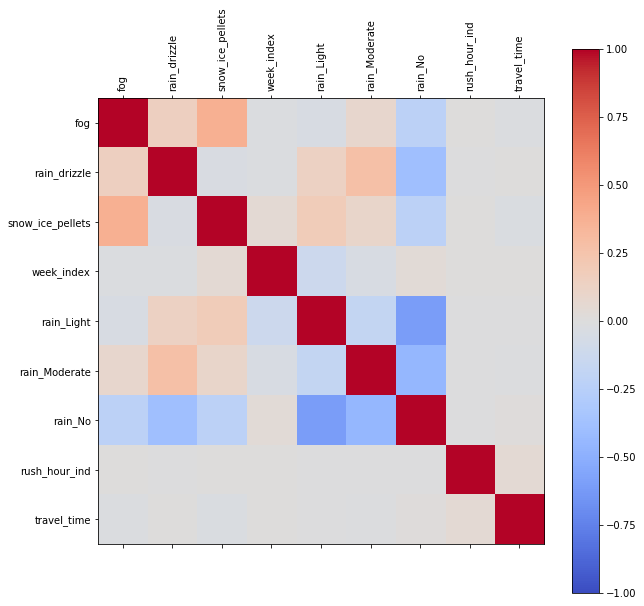

In [29]:
corr = df_corr_cat.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_corr_cat.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_corr_cat.columns)
ax.set_yticklabels(df_corr_cat.columns)
plt.show()

### From the heatmap above, the correlations bewteen categorical variables are weak.

### The following graphs are the scatter plots of continuous vairables.

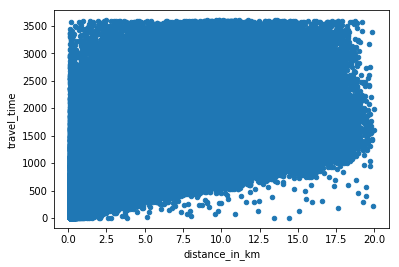

In [30]:
df_final.plot(x='distance_in_km',y='travel_time',kind='scatter')

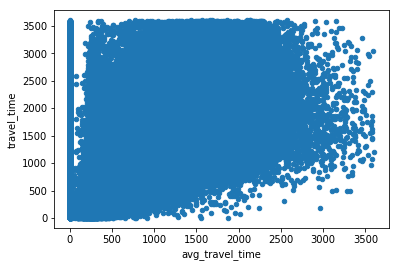

In [31]:
df_final.plot(x='avg_travel_time',y='travel_time',kind='scatter')

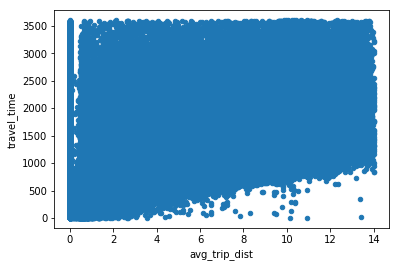

In [32]:
df_final.plot(x='avg_trip_dist',y='travel_time',kind='scatter')

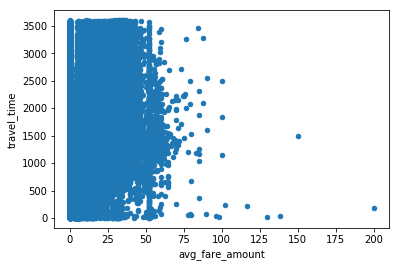

In [33]:
df_final.plot(x='avg_fare_amount', y='travel_time',kind='scatter')

### From the scatter plots above, we can see the continuous variables do not have too much linear trend with travel_time.